# Turing Target Practice

## Model

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../")
Pkg.instantiate()

  Activating project at `~/PhD/MicroCanonicalHMC.jl/examples`
   Resolving package versions...
    Updating `~/PhD/MicroCanonicalHMC.jl/examples/Project.toml`
  [234d2aa0] ~ MicroCanonicalHMC v0.1.0 `..#master` ⇒ v0.1.0 `..`
    Updating `~/PhD/MicroCanonicalHMC.jl/examples/Manifest.toml`
  [234d2aa0] ~ MicroCanonicalHMC v0.1.0 `..#master` ⇒ v0.1.0 `..`
Precompiling project...
  ✓ MicroCanonicalHMC
  1 dependency successfully precompiled in 4 seconds. 271 already precompiled.


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ truncated(Normal(0.3, 0.05), 0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
spl = MCHMC(10_000, 0.5; sigma=ones(target.d), adaptive=true)
samples_mchmc = Sample(spl, target, 100_000;
                       initial_x = [0.2, 0.8],  
                       dialog=true)

[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):   0%|                                   |  ETA: 0:44:49

Burn in step: 2000
eps --->0.07760940443702344


MCHMC (tuning):  20%|███████                            |  ETA: 0:00:06

L   --->0.009679223936449976
 


MCHMC (tuning):  38%|█████████████▎                     |  ETA: 0:00:03

Burn in step: 4000
eps --->0.07803019397060931
L   --->0.010920392545538692
 


MCHMC (tuning):  58%|████████████████████▍              |  ETA: 0:00:01

Burn in step: 6000
eps --->0.07216933119714194
L   --->0.011810381587186006
 


MCHMC (tuning):  79%|███████████████████████████▌       |  ETA: 0:00:00

Burn in step: 8000
eps --->0.07953057440704184
L   --->0.013457361895821626
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:01

Burn in step: 10000
eps --->0.07944339099167799
L   --->0.013408656695742024
 


[ Info: eps: 0.07944339099167799
[ Info: L: 0.013408656695742024
[ Info: nu: 258.9832254637951
[ Info: sigma: [1.0, 1.0]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:00:04

100000-element Vector{Any}:
 [0.3108511035609615, 0.822395242011046, 0.07944339099167799, -0.004842957461345776, 17.058541983491395]
 [0.3089575333579116, 0.743996569107937, 0.07993769562484135, 0.3396281448357463, 15.169312586429015]
 [0.3085699156972022, 0.8238910431766161, 0.08038125365647746, -0.036869614670829165, 17.098212271873702]
 [0.30807915221564647, 0.743578697954302, 0.0806480454339674, 0.0034124507878523502, 15.139855181000613]
 [0.31781209014871253, 0.6972879440734914, 0.07582308273017772, 3.4176001917853522, 11.843154765772981]
 [0.31847603949513736, 0.7729767609545928, 0.07631926870549863, -0.28449107054100153, 16.38963484090755]
 [0.3182805664523998, 0.849284475280488, 0.07679299606735004, 0.07101614857099747, 16.306207132697747]
 [0.3282885806333235, 0.8138312832337649, 0.077109879797807, -0.6593341322400299, 16.649832871195258]
 [0.31729409067810443, 0.8324840291782079, 0.07762266523335662, 0.18646422319325495, 16.758002012350506]
 [0.3061459836202143, 0.81500303483

In [9]:
std(samples_mchmc)[1:end-3]

2-element Vector{Float64}:
 0.038370649010132304
 0.0534209399989353

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

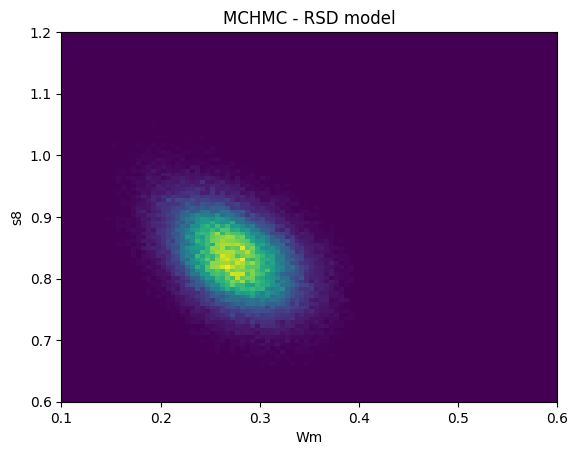

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [12]:
samples_hmc = sample(stat_model, NUTS(1_000, 0.65),
                     50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:10


Chains MCMC chain (50000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:51000
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 14.42 seconds
Compute duration  = 14.42 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

          Ωm    0.2748    0.0433    0.0003   25509.6118   29580.5350    1.0000 ⋯
          σ8    0.8348    0.0448    0.0003   26242.9228   27785.2612    1.0000 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

   

In [13]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

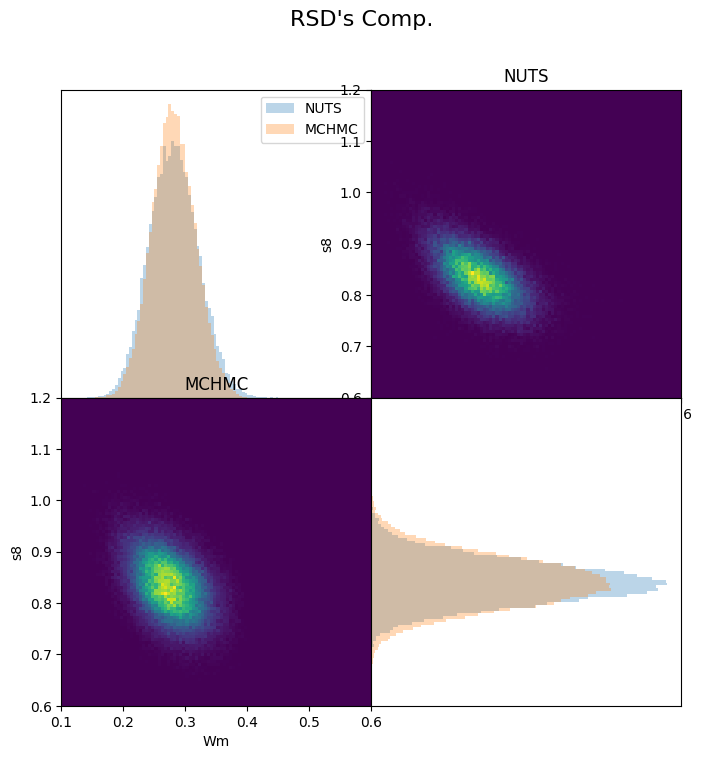

In [14]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("RSD's Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(Wms_hmc, bins=100, density=true, range=[0.1, 0.6], alpha = 0.3, label="NUTS")
axis[1,1].hist(Wms_mchmc, bins=100, density=true, range=[0.1, 0.6], alpha = 0.3, label="MCHMC")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(s8s_hmc, bins=100, density=true, orientation="horizontal", range=[0.6, 1.2], alpha = 0.3)
axis[2,2].hist(s8s_mchmc, bins=100, density=true, orientation="horizontal", range=[0.6, 1.2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]])
axis[1,2].set_xlabel("Wm")
axis[1,2].set_ylabel("s8")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]])
axis[2,1].set_xlabel("Wm")
axis[2,1].set_ylabel("s8")
axis[2,1].set_title("MCHMC")
;